In [ ]:
!pip install causalml

In [3]:

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from xgboost import XGBRegressor
import warnings

from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.match import NearestNeighborMatch, MatchOptimizer, create_table_one
from causalml.propensity import ElasticNetPropensityModel
from causalml.dataset import *
from causalml.metrics import *

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

%matplotlib inline

# PROPENSITY SCORE ESTIMATION

A propensity score is the probability that a unit with certain characteristics will be assigned to the treatment group (as opposed to the control group)

In [5]:
from causalml.dataset import synthetic_data
y, X, treatment, _, _, e = synthetic_data(mode=1, n=1000, p=5, sigma=1.0)
#y, X, treatment, tau, b, e = synthetic_data(mode=1)

In [6]:
from causalml.propensity import ElasticNetPropensityModel
pm = ElasticNetPropensityModel(n_fold=5, random_state=42)
ps = pm.fit_predict(X,treatment)

In [7]:
ps[0:5]

array([0.4736867 , 0.3220054 , 0.3719165 , 0.59245763, 0.65557444])

# PROPENSITY SCORE MATCHING

**Theory**: When the treatment and non-treatment groups are not comparable, that is, when the distributions or the ranges of the confounding covariates vary across the control and treatment groups, the coefficient estimates are biased [1].  
**Matching** techniques ensure balanced distribution by identifying pairs of data points in treatment and non-treatment groups that are close to each other, with the confounding covariates defining the distance between the pair. Those techniques output a smaller dataset where each treatment observation matches with one (or more) non-treatment observations that are the closest to it

In [8]:
import pandas as pd

In [9]:
df = pd.DataFrame(X)
df['treatment'] = treatment
df['prop_score'] = ps
df['y'] = y
df.columns = ['x1','x2','x3','x4','x5','treatment','prop_score','y']
df

,x1,x2,x3,x4,x5,treatment,prop_score,y
0,0.589448,0.289477,0.267146,0.825123,0.313413,0,0.473687,1.583975
1,0.612086,0.062653,0.097152,0.158551,0.666716,0,0.322005,-0.391810
2,0.526743,0.227053,0.606917,0.663398,0.304564,0,0.371917,1.627970
3,0.277414,0.816930,0.424102,0.633025,0.590874,0,0.592458,0.708206
4,0.597671,0.597610,0.166984,0.217358,0.543806,1,0.655574,1.293573
...,...,...,...,...,...,...,...,...
995,0.886264,0.689955,0.553014,0.905073,0.121124,1,0.855419,3.988824
996,0.391942,0.882328,0.844484,0.849820,0.286753,1,0.701045,2.451749
997,0.516885,0.682379,0.671942,0.790297,0.913063,1,0.668246,3.250837
998,0.019441,0.777689,0.247172,0.432763,0.659230,0,0.383600,1.289049


In [10]:
from causalml.match import NearestNeighborMatch, create_table_one

psm = NearestNeighborMatch(replace=False,
                           ratio=1,
                           random_state=42)
matched = psm.match(data=df, 
                    treatment_col='treatment', 
                    score_cols=['prop_score']
                    )

In [11]:
matched

,x1,x2,x3,x4,x5,treatment,prop_score,y
997,0.516885,0.682379,0.671942,0.790297,0.913063,1,0.668246,3.250837
746,0.409135,0.276489,0.685943,0.547138,0.903564,1,0.323323,0.059237
12,0.520566,0.548848,0.304033,0.696398,0.052316,1,0.588024,1.166997
369,0.638707,0.569312,0.956356,0.257041,0.528970,1,0.643694,0.937338
168,0.553361,0.874899,0.534475,0.240958,0.224759,1,0.769961,1.508195
...,...,...,...,...,...,...,...,...
486,0.031252,0.892665,0.766443,0.905995,0.666512,0,0.473196,2.268119
505,0.585045,0.258683,0.295469,0.239932,0.625460,0,0.423722,2.057676
211,0.494664,0.442701,0.470073,0.154031,0.605576,0,0.472441,-0.287603
628,0.490751,0.358757,0.828008,0.368113,0.143040,0,0.410067,2.622183


In [12]:
matched[matched['prop_score'].round(2)==0.13]

,x1,x2,x3,x4,x5,treatment,prop_score,y


In [13]:
# A table with the means and standard deviations in the treatment and control groups, and the standard mean difference (SMD) between two groups for the features.
create_table_one(data=matched,
                 treatment_col='treatment',
                 features=['x1','x2','x3','x4','x5'])

,Control,Treatment,SMD
Variable,,,
n,256,256,
x1,0.51 (0.31),0.51 (0.26),0.0123
x2,0.50 (0.31),0.50 (0.26),-0.01
x3,0.50 (0.28),0.49 (0.29),-0.0372
x4,0.52 (0.28),0.52 (0.29),-0.0055
x5,0.49 (0.30),0.48 (0.30),-0.0503


# Average Treatment Effect (ATE) Estimation

In [14]:
X=df[['x1','x2','x3','x4','x5']]
treatment=df['treatment']
e=df['prop_score']
y=df['y']

In [15]:
from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.meta import BaseXRegressor
from causalml.inference.meta import BaseRRegressor
from xgboost import XGBRegressor
from causalml.dataset import synthetic_data

#y, X, treatment, _, _, e = synthetic_data(mode=1, n=1000, p=5, sigma=1.0)

lr = LRSRegressor()
te, lb, ub = lr.estimate_ate(X, treatment, y)
print('Average Treatment Effect (Linear Regression): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

xg = XGBTRegressor(random_state=42)
te, lb, ub = xg.estimate_ate(X, treatment, y)
print('Average Treatment Effect (XGBoost): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

nn = MLPTRegressor(hidden_layer_sizes=(10, 10),
                 learning_rate_init=.1,
                 early_stopping=True,
                 random_state=42)
te, lb, ub = nn.estimate_ate(X, treatment, y)
print('Average Treatment Effect (Neural Network (MLP)): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

xl = BaseXRegressor(learner=XGBRegressor(random_state=42))
te, lb, ub = xl.estimate_ate(X=X, p=e, treatment=treatment, y=y)
print('Average Treatment Effect (BaseXRegressor using XGBoost): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

rl = BaseRRegressor(learner=XGBRegressor(random_state=42))
te, lb, ub =  rl.estimate_ate(X=X, p=e, treatment=treatment, y=y)
print('Average Treatment Effect (BaseRRegressor using XGBoost): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

Average Treatment Effect (Linear Regression): 0.79 (0.64, 0.93)
[00:57:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:57:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Average Treatment Effect (XGBoost): 0.72 (0.62, 0.81)
Average Treatment Effect (Neural Network (MLP)): 1.00 (0.87, 1.12)
[00:57:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:57:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:57:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:57:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Average Treatment Effect (BaseXRegressor using XGBoos

# Calculate Individual Treatment Effect (ITE/CATE)

In [16]:
# S Learner
learner_s = LRSRegressor()
cate_s = learner_s.fit_predict(X=X, treatment=treatment, y=y)

# T Learner
learner_t = BaseTRegressor(learner=XGBRegressor())
cate_t = learner_t.fit_predict(X=X, treatment=treatment, y=y)

# X Learner with propensity score input
learner_x = BaseXRegressor(learner=XGBRegressor())
cate_x = learner_x.fit_predict(X=X, treatment=treatment, y=y, p=e)

# X Learner without propensity score input
learner_x_no_p = BaseXRegressor(learner=XGBRegressor())
cate_x_no_p = learner_x_no_p.fit_predict(X=X, treatment=treatment, y=y)

# R Learner with propensity score input 
learner_r = BaseRRegressor(learner=XGBRegressor())
cate_r = learner_r.fit_predict(X=X, treatment=treatment, y=y, p=e)

# R Learner without propensity score input
learner_r_no_p = BaseRRegressor(learner=XGBRegressor())
cate_r_no_p = learner_r_no_p.fit_predict(X=X, treatment=treatment, y=y)

[00:57:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:57:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:57:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:57:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:57:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:57:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:57:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:57:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

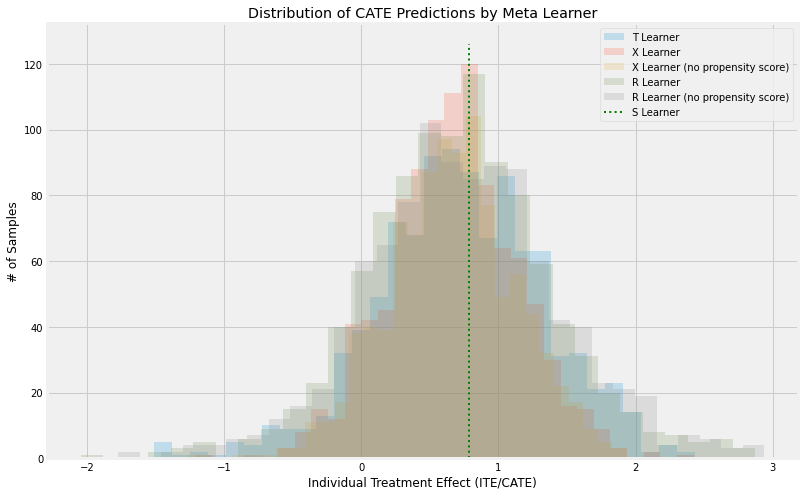

In [17]:

alpha=0.2
bins=30
plt.figure(figsize=(12,8))
plt.hist(cate_t, alpha=alpha, bins=bins, label='T Learner')
plt.hist(cate_x, alpha=alpha, bins=bins, label='X Learner')
plt.hist(cate_x_no_p, alpha=alpha, bins=bins, label='X Learner (no propensity score)')
plt.hist(cate_r, alpha=alpha, bins=bins, label='R Learner')
plt.hist(cate_r_no_p, alpha=alpha, bins=bins, label='R Learner (no propensity score)')
plt.vlines(cate_s[0], 0, plt.axes().get_ylim()[1], label='S Learner',
           linestyles='dotted', colors='green', linewidth=2)
plt.title('Distribution of CATE Predictions by Meta Learner')
plt.xlabel('Individual Treatment Effect (ITE/CATE)')
plt.ylabel('# of Samples')
_=plt.legend()

#Validating Meta-Learner Accuracy

In [ ]:
train_summary, validation_summary = get_synthetic_summary_holdout(simulate_nuisance_and_easy_treatment,
                                                                  n=10000,
                                                                  valid_size=0.2,
                                                                  k=10)

In [19]:
train_summary

,Abs % Error of ATE,MSE,KL Divergence
Actuals,0.000000,0.000000,0.000000
S Learner (LR),0.378591,0.079007,3.741208
S Learner (XGB),0.146064,0.025451,0.154369
T Learner (LR),0.356653,0.037528,0.320903
T Learner (XGB),0.171701,0.079693,0.315601
X Learner (LR),0.356653,0.037528,0.320903
X Learner (XGB),0.097481,0.035743,0.099622
R Learner (LR),0.295214,0.037779,0.310341
R Learner (XGB),0.067838,0.062235,0.085774


In [20]:
validation_summary

,Abs % Error of ATE,MSE,KL Divergence
Actuals,0.000000,0.000000,0.000000
S Learner (LR),0.375088,0.078524,3.705406
S Learner (XGB),0.144858,0.024973,0.182719
T Learner (LR),0.356750,0.037478,0.354037
T Learner (XGB),0.176373,0.076599,0.340572
X Learner (LR),0.356750,0.037478,0.354037
X Learner (XGB),0.100055,0.033980,0.120777
R Learner (LR),0.296505,0.037681,0.347183
R Learner (XGB),0.069204,0.059819,0.103714


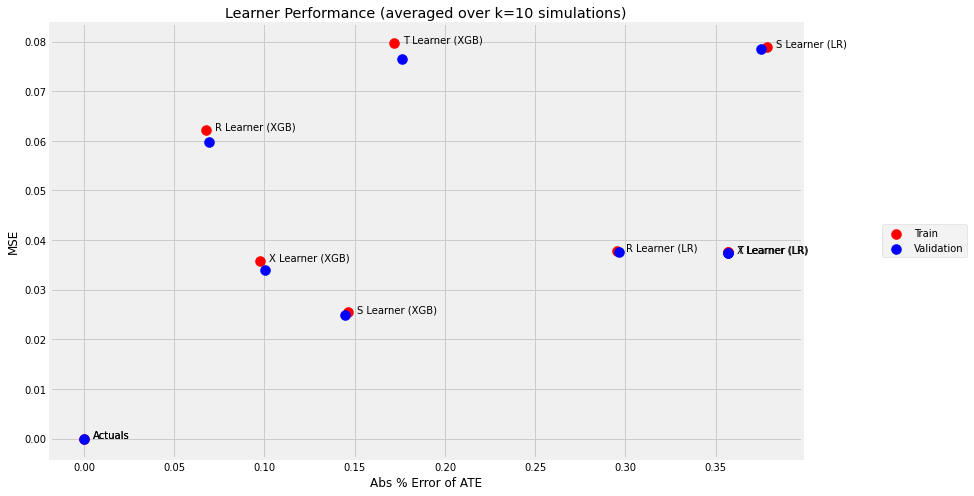

In [21]:

scatter_plot_summary_holdout(train_summary,
                             validation_summary,
                             k=10,
                             label=['Train', 'Validation'],
                             drop_learners=[],
                             drop_cols=[])

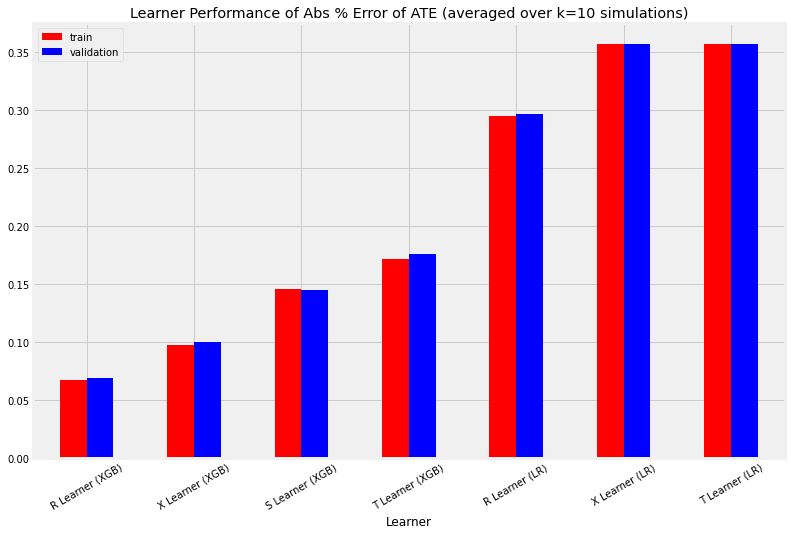

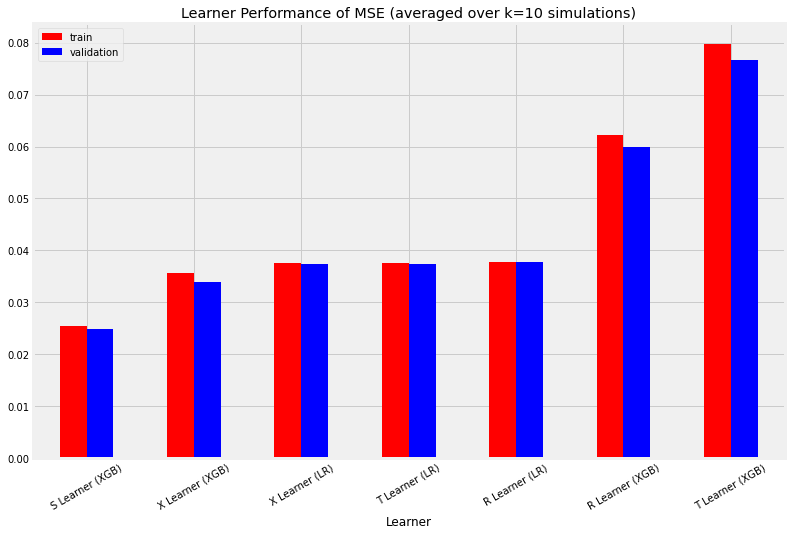

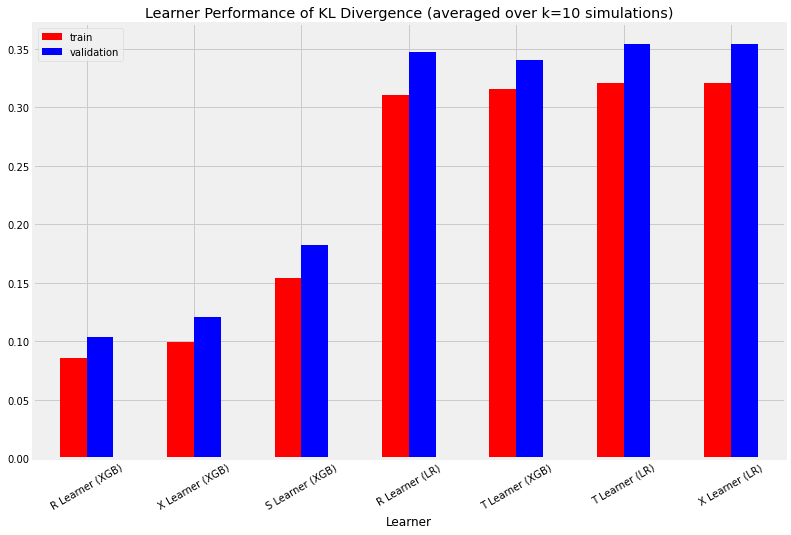

In [22]:
bar_plot_summary_holdout(train_summary,
                         validation_summary,
                         k=10,
                         drop_learners=['S Learner (LR)'],
                         drop_cols=[])